### [Day3]
* Day1 and 2のフィードバックを元に説明変数を変更
* Pledged、backersは利用しないように変更
* main_category、currency、goal、deadline、launched、stateを使用
* フィードバックを元にsuccessful、failedのみを残しその他は削除
* Day3までの内容（評価できた手法）で精度の比較を実施
 
* ホールドアウト（標準化なし）53.7 %
* 交差検証（標準化なし）56.0 %
* ホールドアウト（標準化あり）64.3 %
* 交差検証（標準化あり）56.0 %
* 決定木　72.4 %
* ランダムフォレスト　72.2 %
* 重くて動かなかったもの(SVM)やエラーがでたまま時間切れになった手法（NN）については後日取り組む予定


In [37]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

#from common_func import plot_decision_regions

In [3]:
#データセットのインポート
df_project=pd.read_csv("../1_data/ks-projects-201801.csv")[["main_category","currency","goal","deadline","launched","state"]]

#表示
display(df_project.head(20))
df_project.describe()
df_project.info()

,main_category,currency,goal,deadline,launched,state
0,Publishing,GBP,1000.0,2015-10-09,2015-08-11 12:12:28,failed
1,Film & Video,USD,30000.0,2017-11-01,2017-09-02 04:43:57,failed
2,Film & Video,USD,45000.0,2013-02-26,2013-01-12 00:20:50,failed
3,Music,USD,5000.0,2012-04-16,2012-03-17 03:24:11,failed
4,Film & Video,USD,19500.0,2015-08-29,2015-07-04 08:35:03,canceled
5,Food,USD,50000.0,2016-04-01,2016-02-26 13:38:27,successful
6,Food,USD,1000.0,2014-12-21,2014-12-01 18:30:44,successful
7,Food,USD,25000.0,2016-03-17,2016-02-01 20:05:12,failed
8,Design,USD,125000.0,2014-05-29,2014-04-24 18:14:43,canceled
9,Film & Video,USD,65000.0,2014-08-10,2014-07-11 21:55:48,canceled


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 6 columns):
main_category    378661 non-null object
currency         378661 non-null object
goal             378661 non-null float64
deadline         378661 non-null object
launched         378661 non-null object
state            378661 non-null object
dtypes: float64(1), object(5)
memory usage: 17.3+ MB


In [4]:
#stateの中身を確認
print(df_project.state.value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [5]:
#日数計算
df_project['deadline'] = pd.to_datetime(df_project['deadline'],format='%Y-%m-%d')
df_project['launched'] = pd.to_datetime(df_project['launched'],format='%Y-%m-%d')

df_project['count'] = (df_project['deadline'] - df_project['launched']).astype('timedelta64[D]')
count = df_project['count'].value_counts()

In [6]:
display(df_project.head())

,main_category,currency,goal,deadline,launched,state,count
0,Publishing,GBP,1000.0,2015-10-09,2015-08-11 12:12:28,failed,58.0
1,Film & Video,USD,30000.0,2017-11-01,2017-09-02 04:43:57,failed,59.0
2,Film & Video,USD,45000.0,2013-02-26,2013-01-12 00:20:50,failed,44.0
3,Music,USD,5000.0,2012-04-16,2012-03-17 03:24:11,failed,29.0
4,Film & Video,USD,19500.0,2015-08-29,2015-07-04 08:35:03,canceled,55.0


In [7]:
print(df_project.state.value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [8]:
#successful、failedのみを残しその他は削除
df_project_test = df_project.copy()
df_project_test = df_project_test[df_project_test['state'] != 'live']
df_project_test = df_project_test[df_project_test['state'] != 'canceled']
df_project_test = df_project_test[df_project_test['state'] != 'suspended']
df_project_test = df_project_test[df_project_test['state'] != 'undefined']
df_project_test['Success'] = df_project_test['state'] == "successful"
print(df_project_test.state.value_counts())

failed        197719
successful    133956
Name: state, dtype: int64


In [9]:
display(df_project_test.head())

,main_category,currency,goal,deadline,launched,state,count,Success
0,Publishing,GBP,1000.0,2015-10-09,2015-08-11 12:12:28,failed,58.0,False
1,Film & Video,USD,30000.0,2017-11-01,2017-09-02 04:43:57,failed,59.0,False
2,Film & Video,USD,45000.0,2013-02-26,2013-01-12 00:20:50,failed,44.0,False
3,Music,USD,5000.0,2012-04-16,2012-03-17 03:24:11,failed,29.0,False
5,Food,USD,50000.0,2016-04-01,2016-02-26 13:38:27,successful,34.0,True


In [10]:
#state等を削除
drop_columns = ['state','deadline','launched']
df_project_test = df_project_test.drop(drop_columns, axis = 1)

In [11]:
df_project_test.isnull().sum()

main_category    0
currency         0
goal             0
count            0
Success          0
dtype: int64

In [12]:
#ダミー変数作成
df_project_test=pd.get_dummies(df_project_test)
display(df_project_test.head())

,goal,count,Success,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,1000.0,58.0,False,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.0,59.0,False,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,44.0,False,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,29.0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0,34.0,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


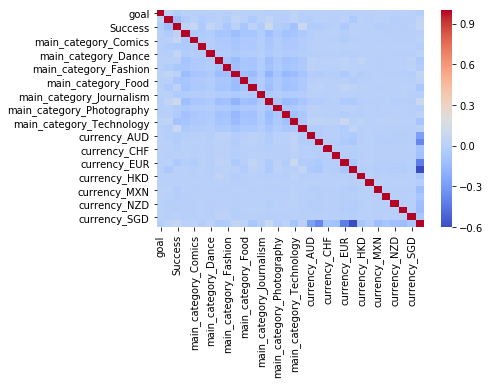

In [13]:
#相関マップ
#df_project.corr().style.background_gradient(cmap='coolwarm')
#sns.heatmap(df_project.corr(), cmap='coolwarm', vmin=-1, vmax=1
sns.heatmap(df_project_test.corr(),cmap="coolwarm")

In [ ]:
#散布図を作成
#pd.plotting.scatter_matrix(df_project_test.head(1000), figsize=(10,10))

In [14]:
y = df_project_test["Success"].values
X = df_project_test.drop('Success', axis=1).values

In [15]:
#ホールドアウト法を使用
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [16]:
#ロジスティック回帰を実装（標準化なし）
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
w7 = clf.coef_[0, 6]
w8 = clf.coef_[0, 7]
w9 = clf.coef_[0, 8]
w10 = clf.coef_[0, 9]
w11 = clf.coef_[0, 10]
w12 = clf.coef_[0, 11]
w13 = clf.coef_[0, 12]
w14 = clf.coef_[0, 13]
w15 = clf.coef_[0, 14]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f},w8 = {:.3f}, w9 = {:.3f}, w10 = {:.3f}, w11 = {:.3f}, w12 = {:.3f},w13 = {:.3f}, w14 = {:.3f}, w15 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14, w15))

w0 = 8239.281, w1 = -545.635, w2 = 206481.500, w3 = 540.181, w4 = 560.220, w5 = -227.914, w6 = 296.700, w7 = 1041.194,w8 = -102.407, w9 = 1853.440, w10 = 164.057, w11 = 1234.524, w12 = -69.875,w13 = 1994.457, w14 = -29.799, w15 = 119.838


In [17]:
# ラベルを予測
y_est = clf.predict(X_train)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est)))

対数尤度 = -15.976
正答率 = 53.745%


In [18]:
# ラベルを予測
y_est2 = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est2)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est2)))

対数尤度 = -16.056
正答率 = 53.513%


In [19]:
# 予測値と正解のクロス集計
conf_mat2 = pd.DataFrame(confusion_matrix(y_test, y_est2), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat2

,予測 = 失敗,予測 = 成功
正解 = 失敗,14333,25395
正解 = 成功,5442,21165


In [20]:
#交差検証法 関数cross_val_scoreでも同じ（標準化なし）
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train, y_train)

    # 予測を実行
    y_est = clf.predict(X_test)
    y_est_t = clf.predict(X_train)

    # 対数尤度を表示
    print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))
    print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_t)))

    # 正答率を表示
    print('正答率_test = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))
    print('正答率_train = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_t)))
    
    # 予測値と正解のクロス集計
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
    display(conf_mat)
    print()


対数尤度 = -13.678
対数尤度 = -13.800
正答率_test = 60.399%
正答率_train = 60.044%


,予測 = 失敗,予測 = 成功
正解 = 失敗,38073,1655
正解 = 成功,24614,1993



対数尤度 = -16.794
対数尤度 = -16.818
正答率_test = 51.379%
正答率_train = 51.309%


,予測 = 失敗,予測 = 成功
正解 = 失敗,10472,28987
正解 = 成功,3266,23610



対数尤度 = -13.965
対数尤度 = -13.873
正答率_test = 59.567%
正答率_train = 59.833%


,予測 = 失敗,予測 = 成功
正解 = 失敗,39169,280
正解 = 成功,26541,345



対数尤度 = -16.328
対数尤度 = -16.293
正答率_test = 52.726%
正答率_train = 52.829%


,予測 = 失敗,予測 = 成功
正解 = 失敗,12643,26898
正解 = 成功,4461,22333



対数尤度 = -15.241
対数尤度 = -15.339
正答率_test = 55.872%
正答率_train = 55.590%


,予測 = 失敗,予測 = 成功
正解 = 失敗,17115,22427
正解 = 成功,6845,19948


(array([6.6308e+04, 6.0000e+00, 4.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.1000e+01]),
 array([-3.80310197e-02,  7.00703421e+00,  1.40520994e+01,  2.10971647e+01,
         2.81422299e+01,  3.51872951e+01,  4.22323604e+01,  4.92774256e+01,
         5.63224908e+01,  6.33675560e+01,  7.04126213e+01]),
 <a list of 10 Patch objects>)

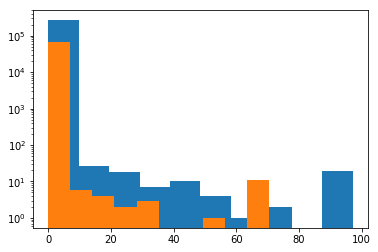

In [50]:
#標準化を実施
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
plt.hist(X_train[:, 0], log=True) 
stdsc = StandardScaler()
X_test = stdsc.fit_transform(X_test)
plt.hist(X_test[:, 0], log=True) 

In [22]:
#ロジスティック回帰を実装（標準化適用）
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
w7 = clf.coef_[0, 6]
w8 = clf.coef_[0, 7]
w9 = clf.coef_[0, 8]
w10 = clf.coef_[0, 9]
w11 = clf.coef_[0, 10]
w12 = clf.coef_[0, 11]
w13 = clf.coef_[0, 12]
w14 = clf.coef_[0, 13]
w15 = clf.coef_[0, 14]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f},w8 = {:.3f}, w9 = {:.3f}, w10 = {:.3f}, w11 = {:.3f}, w12 = {:.3f},w13 = {:.3f}, w14 = {:.3f}, w15 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14, w15))

w0 = -0.940, w1 = -20.811, w2 = -0.248, w3 = 0.031, w4 = 0.139, w5 = -0.097, w6 = 0.098, w7 = 0.070,w8 = -0.134, w9 = 0.057, w10 = -0.118, w11 = 0.083, w12 = -0.160,w13 = 0.112, w14 = -0.084, w15 = -0.096


In [23]:
# ラベルを予測
y_est = clf.predict(X_train)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_est)))

対数尤度 = -12.311
正答率 = 64.356%


In [24]:
# ラベルを予測
y_est2 = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est2)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est2)))

対数尤度 = -12.322
正答率 = 64.325%


In [25]:
#交差検証法 （標準化を適用）
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train, y_train)

    # 予測を実行
    y_est = clf.predict(X_test)
    y_est_t = clf.predict(X_train)

    # 対数尤度を表示
    print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))
    print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_t)))

    # 正答率を表示
    print('正答率_test = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))
    print('正答率_train = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_t)))
    
    # 予測値と正解のクロス集計
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
    display(conf_mat)
    print()

対数尤度 = -13.678
対数尤度 = -13.800
正答率_test = 60.399%
正答率_train = 60.044%


,予測 = 失敗,予測 = 成功
正解 = 失敗,38073,1655
正解 = 成功,24614,1993



対数尤度 = -16.794
対数尤度 = -16.818
正答率_test = 51.379%
正答率_train = 51.309%


,予測 = 失敗,予測 = 成功
正解 = 失敗,10472,28987
正解 = 成功,3266,23610



対数尤度 = -13.965
対数尤度 = -13.873
正答率_test = 59.567%
正答率_train = 59.833%


,予測 = 失敗,予測 = 成功
正解 = 失敗,39169,280
正解 = 成功,26541,345



対数尤度 = -16.328
対数尤度 = -16.293
正答率_test = 52.726%
正答率_train = 52.829%


,予測 = 失敗,予測 = 成功
正解 = 失敗,12643,26898
正解 = 成功,4461,22333



対数尤度 = -15.241
対数尤度 = -15.339
正答率_test = 55.872%
正答率_train = 55.590%


,予測 = 失敗,予測 = 成功
正解 = 失敗,17115,22427
正解 = 成功,6845,19948


In [ ]:
#SVM　処理が終わらず断念
#parameters = {'kernel':['linear', 'rbf'], 'C':[1, 1]} # ここを編集する
#model = SVC()
#clf = GridSearchCV(model, parameters, cv=3,)
#clf.fit(X_train, y_train)
#print(clf.best_params_, clf.best_score_)

In [16]:
#決定木を用いた評価
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))
print(clf.predict(X_test)) #予測したい場合

score= 0.7239089470113816
[ True  True  True ... False False False]


[4.60765853e-01 2.52983568e-01 1.08347782e-02 1.74079945e-02
 8.36789264e-03 9.18714243e-03 1.34331976e-02 1.56201970e-02
 1.76004144e-02 1.04648914e-02 1.35418393e-02 5.04897495e-03
 2.55676976e-02 6.28613257e-03 1.19057560e-02 1.35976926e-02
 2.28174460e-02 6.56832393e-03 1.08578398e-02 6.55968826e-04
 1.85029423e-03 1.16516477e-02 1.65181599e-02 1.57291876e-03
 5.74292523e-05 1.46052213e-03 7.17453028e-04 1.01520656e-03
 2.50916873e-03 4.90293661e-04 2.86433056e-02]


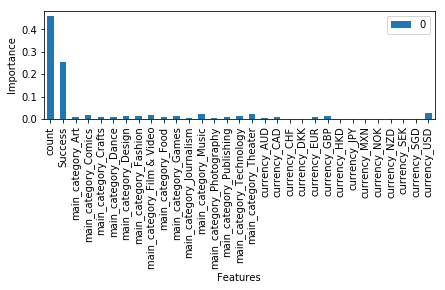

In [17]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, df_project_test.columns[1:]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [18]:
# 時間の都合で一時保留としています
# 決定木の描画
#dot_data = StringIO() #dotファイル情報の格納先
#export_graphviz(clf, out_file=dot_data,  
#                     feature_names=df_project_test.columns[1:],  
#                     class_names=["True","False"],  
#                     filled=True, rounded=True,  
#                     special_characters=True) 
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
#Image(graph.create_png())

NameError: name 'StringIO' is not defined

score= 0.7219190472601191
[5.11172147e-01 2.84099068e-01 3.73708767e-03 1.52529381e-02
 8.98901864e-03 1.00220870e-02 5.92246458e-03 1.32342819e-02
 6.97090612e-03 1.19902218e-02 6.56566162e-03 4.88561546e-03
 2.80009458e-02 4.11301468e-03 9.33821760e-03 2.11635310e-02
 2.17539330e-02 2.62646382e-03 3.26498741e-03 7.49836127e-04
 1.30586504e-03 6.85433649e-03 4.16031507e-03 1.24175778e-03
 8.48819765e-05 1.37547620e-03 6.14981026e-04 1.16394842e-03
 1.62308175e-03 6.63928706e-04 7.05900009e-03]


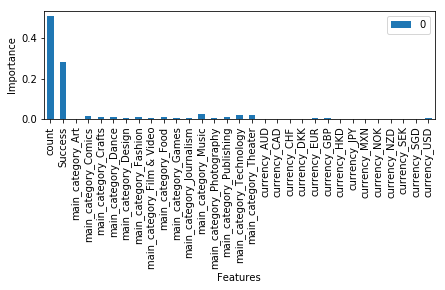

In [35]:
#ランダムフォレストを用いた評価 scoreはmax_depth=30付近で頭打ち
clf = RandomForestClassifier(n_estimators=10, max_depth=30, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, df_project_test.columns[1:]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [45]:
# NNを用いた評価 エラーの内容については時間切れです

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=4))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

In [46]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

ValueError: Error when checking input: expected dense_12_input to have shape (4,) but got array with shape (31,)